# BANNER: EDGI and EEW LOGOS
###### This notebook is available under the GPL 3.0 license. Brief description.
###### Link to EDGI's authorship protocol: XXXXXXXXX.

# Tracking EPA's COVID-19 non-enforcement policy
In late March 2020, EPA released a memo announcing that it would not penalize regulated industries that fail to meet their monitoring and reporting requirements due to COVID-19. Specifically EPA has said that it:

> "is not seeking penalties for noncompliance only in circumstances that involve routine monitoring and reporting requirements, if, on a case-by-case basis, EPA agrees that such noncompliance was caused by the COVID-19 pandemic."

This may have a number of public and environmental health impacts if facilities respond by increasing their emissions and discharges. Our response to this memo states that the EPA’s COVID-19 leniency is [a “free pass to poullute.](https://envirodatagov.org/epas-covid-19-leniency-is-a-free-pass-to-pollute/)”

## What is the effect of EPA's non-enforcement of Clean Air Act and Clean Water Act permits? 
Using this notebook, you can track how facilities' releases—as well as monitoring and reporting—of air and water hazards has changed in your state over the past few months, compared to previous years. 

There are three scenarios we may see playing out:

_Monitoring and reporting violations_
- 1. **Facilities that do *not* report** (we can track this)....**but do still meet their permit limits** (yet we can't know this specifically, precisely because they didn't report)
- 2. **Facilities that do *not* report** (we can track this)....**and actually exceed their limits** (yet we can't know this specifically, precisely because they didn't report)

_Environmental violations_
- 3. **Facilities that do meet their reporting obligations** BUT they **report having exceeded their permitted limits**

Organization of this notebook:
 - Air emissions
 - Water discharges from major sources 
 - Water quality monitoring and reporting violations
---

## How to Run this Notebook
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue. 
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* The code cell in the "Pick a month" section will create a dropdown menu after you run it. Be sure to make a selection before running the next cell.
* **After you run the first cell and select a month, you can then select "Run after" from the "Runtime" menu to automatically run the rest of the notebook.**
* Other cells will simply print information when you run them, like this one:
![Simple cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/cell-simple.JPG?raw=true)
* And yet others will display charts or maps.
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!

---

## Setup
Here we load some helper code to get us going.

In [1]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import csv
import datetime
import folium
import ipywidgets as widgets
colour = "#00C2AB" # The default colour for the barcharts

/Users/enost/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# This will make all of our charts for us
def charter (full_data, date_column, date_format, counting_column, measure, filename, title, function):
    full_data[date_column] = pd.to_datetime(full_data[date_column], format=date_format) #format the date

    this_data = full_data.groupby([date_column])[counting_column].agg(function) # for each day, count the number of inspections/enforcements/violations
    this_data = this_data.resample('M').sum() #resample and summarize on a monthly basis  
    this_data = this_data.loc[(this_data.index.month == int(mnth)) & (this_data.index.year >= 2001)] # Filter to higher quality data timeframe and back to just the selected month 
    this_data = pd.DataFrame(this_data)
    this_data = this_data.rename(columns={counting_column: measure})
    this_data.index = this_data.index.strftime('%Y-%m') # makes the x axis (date) prettier

    ax = this_data.plot(kind='bar', title = title, figsize=(20, 10), fontsize=16, color=colour)
    ax

    #label trendline
    trend=this_data[measure].mean()
    ax.axhline(y=trend, color='r', linestyle='-', label = "Long term average")

    #label past 4 years trend (2017, 2018, 2019)
    trend_month=pd.concat([this_data.loc["2017-"+mnth],this_data.loc["2018-"+mnth],this_data.loc["2019-"+mnth]])
    trend_month=trend_month[measure].mean()
    ax.axhline(y=trend_month, xmin = .82, xmax=.93, color='y', linestyle='-', label = "Recent average")

    #export data 
    this_data.to_csv(filename) 

In [3]:
def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]]
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.CircleMarker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"],
            radius = 8,
            color = "black",
            weight = 1,
            fill_color = "orange",
            fill_opacity= .4
        ).add_to(m)

    bounds = m.get_bounds()
    m.fit_bounds(bounds)

    # Show the map
    return m

#### Pick a month
We'll look at trends for that month across the past few decades of pollution trends

In [4]:
w=widgets.Dropdown(
    options=["01","02","03","04","05","06","07","08","09","10","11","12"],
    value = "03",
    description='Month:'
)
display(w)

Dropdown(description='Month:', index=2, options=('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '…

In [5]:
mnth=w.value

## Are facilities monitoring their emissions?
"Stack tests" involve measuring the volume of pollutants coming out of the facility's "smokestack".

The following cell will grab EPA data on facility stack tests for every one of the selected months on record (up to 50 years ago). Some pollutant releases may be seasonal, so by looking only at the selected month, we can account for this variation and ensure an apples-to-apples comparison.

In addition, we will only look at data post-2000, as EPA notes that its data systems prior to that date are incomplete and hence "unknown."

In [6]:
sql = "select * from `ICIS-AIR_STACK_TESTS` where ACTUAL_END_DATE like '"+mnth+"/%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

stack_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
stack_data.set_index("pgm_sys_id", inplace=True)
stack_data

,ACTIVITY_ID,COMP_MONITOR_TYPE_CODE,COMP_MONITOR_TYPE_DESC,STATE_EPA_FLAG,ACTUAL_END_DATE,POLLUTANT_CODES,POLLUTANT_DESCS,AIR_STACK_TEST_STATUS_CODE,AIR_STACK_TEST_STATUS_DESC
pgm_sys_id,,,,,,,,,
CT0000000901100054,3400320530,CST,Stack Test,S,03/28/2006,NITROGEN OXIDES NO2,NaN,PSS,Pass
CT0000000900700107,3400332694,CST,Stack Test,S,03/08/2010,NITROGEN OXIDES NO2,NaN,PSS,Pass
MD0000002451000071,3400766780,CST,Stack Test,S,03/17/2011,TOTAL PARTICULATE MATTER,NaN,PSS,Pass
CT0000000901102432,3400333811,CST,Stack Test,S,03/30/2011,TOTAL PARTICULATE MATTER,NaN,PSS,Pass
CT0000000901102432,3400333824,CST,Stack Test,S,03/30/2011,NITROGEN OXIDES NO2,NaN,PSS,Pass
CT0000000900303405,3400340460,CST,Stack Test,S,03/16/2006,Sulfur dioxide,NaN,PSS,Pass
CT0000000901105023,3400311875,CST,Stack Test,S,03/24/2005,NITROGEN OXIDES NO2,NaN,PSS,Pass
CT0000000900300176,3400313462,CST,Stack Test,S,03/09/2011,Ammonia,NaN,PSS,Pass
NY0000002620200167,3400576227,CST,Stack Test,S,03/17/2005,TOTAL PARTICULATE MATTER,NaN,PSS,Pass


#### Now we'll chart this data. 

The height of each bar will indicate how many tests there were, while the red line will show us the average number of these for all previous Aprils and the yellow line indicates the average for the past three years.

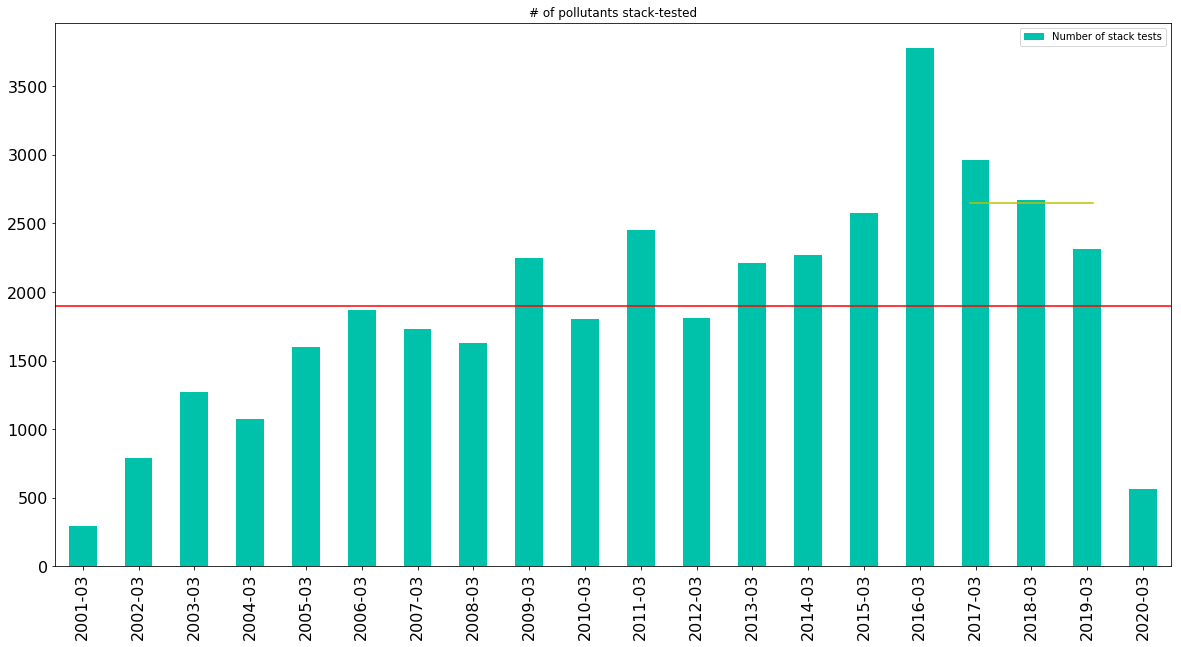

In [7]:
charter(stack_data, 'ACTUAL_END_DATE', "%m/%d/%Y", 'STATE_EPA_FLAG', 
        "Number of stack tests", "air_monitoring.csv", "# of pollutants stack-tested", "count")

#### Are inspections happening?

In [9]:
###### TBD
sql = "select * from `ICIS-AIR_FCES_PCES` where ACTUAL_END_DATE like '"+mnth+"-%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

eval_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
eval_data.set_index("PGM_SYS_ID", inplace=True)
eval_data

,ACTIVITY_ID,STATE_EPA_FLAG,ACTIVITY_TYPE_CODE,ACTIVITY_TYPE_DESC,COMP_MONITOR_TYPE_CODE,COMP_MONITOR_TYPE_DESC,ACTUAL_END_DATE,PROGRAM_CODES
PGM_SYS_ID,,,,,,,,
CASJV00006077N0266,3601880363,L,INS,Inspection/Evaluation,POR,PCE On-Site Record/Report Review,03-04-2019,"CAASIP, CAATVP"
CASJV00006077N0266,3602160026,L,INS,Inspection/Evaluation,POR,PCE On-Site Record/Report Review,03-26-2020,"CAASIP, CAATVP"
CASJV00006077N0283,3402485327,L,INS,Inspection/Evaluation,PCE,PCE On-Site,03-05-2007,CAASIP
CASJV00006077N0283,3402485334,L,INS,Inspection/Evaluation,PCE,PCE On-Site,03-25-2008,CAASIP
CASJV00006077N0283,3402485336,L,INS,Inspection/Evaluation,PCE,PCE On-Site,03-23-2009,CAASIP
CASJV00006077N0283,3402485357,L,INS,Inspection/Evaluation,FFO,FCE Off-Site,03-25-2008,CAASIP
CASJV00006077N0283,3600985313,L,INS,Inspection/Evaluation,POR,PCE On-Site Record/Report Review,03-14-2017,CAASIP
CASJV00006077N0283,3600985890,L,INS,Inspection/Evaluation,FOO,FCE On-Site,03-14-2017,CAASIP
CASJV00006077N0285,3402499721,L,INS,Inspection/Evaluation,PCE,PCE On-Site,03-15-2006,"CAASIP, CAATVP"


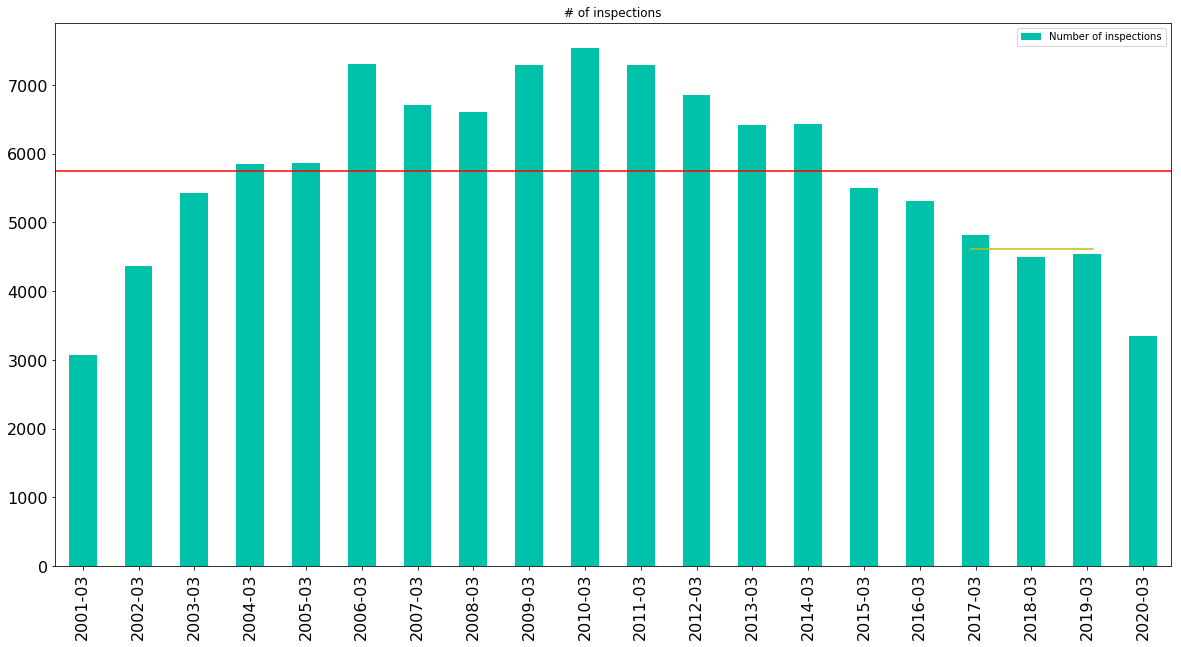

In [14]:
##### TBD
# chart inspections
charter(eval_data, 'ACTUAL_END_DATE', "%m-%d-%Y", 'ACTIVITY_TYPE_DESC', "Number of inspections", 
        "caa_inspections.csv", "# of inspections", "count")

In [ ]:
#### Who should've been stack test/inspected, but wasn't and what did they emit previously?
##of those that didn't report this month, if they had the previous three month/years, 
# then we assume they should have this year. Get those from a list of all air facilities....

In [26]:
### COMPARE TO PREVIOUS YEARS in AIR EMISSIONS TABLE

#sql = "select * from `POLL_RPT_COMBINED_EMISSIONS` where PGM_SYS_ID like 'WA%'"
#url='http://apps.tlt.stonybrook.edu/echoepa/?query='
#data_location=url+urllib.parse.quote(sql)

#emissions_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
#emissions_data.set_index("PGM_SYS_ID", inplace=True)
#emissions_data

EmptyDataError: No columns to parse from file

## What have facilities reporting releasing into the air?
This has ramifications for COVID-19....

First, we'll get this data! We'll start by looking at those facilities that were found to be in violation for their emissions.

In [ ]:
sql = "select * from `ICIS-AIR_VIOLATION_HISTORY` where HPV_DAYZERO_DATE like '"+mnth+"-%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

air_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
air_data.set_index("pgm_sys_id", inplace=True)
air_data

#### Let's chart it!
The height of each bar will indicate how many emissions violations there have been, while the red line will show us the average number of these for all previous years and the yellow line indicates the average for the past three years.

In [ ]:
charter(air_data, 'HPV_DAYZERO_DATE', "%m-%d-%Y", 'ENF_RESPONSE_POLICY_CODE', 
        "Number of violations", "air_violations_total.csv", "# of Clean Air Act violations", "count")

facilities = air_data.reset_index()
facilities = facilities.groupby(['HPV_DAYZERO_DATE']).agg({"pgm_sys_id": "nunique"})
facilities = facilities.reset_index()
charter(facilities, 'HPV_DAYZERO_DATE', "%m/%d/%Y", 'pgm_sys_id', "Number of facilities exceeding", 
        "caa_violations_facilities.csv", "# of facilities exceeding", "sum")

In [ ]:
### MAP THESE FACILITIES
### INSTEAD OF CPS, JUST PIE CHART WHAT IS BEING VIOLATED?

Let's break it down by type of pollutant. We'll focus on two of what EPA calls "criteria pollutants" - those that have such an impact on human health, that the agency regulates how much of these can be in the atmosphere at any given time/place. The two are particulate matter, which is known to affect the circulatory and nervous systems, and sulfur dioxide, which exacerbates asthma.

In [ ]:
cps = air_data
cps = cps[(cps['POLLUTANT_DESCS'].astype(str).str.contains('Particulate')) | (cps['POLLUTANT_DESCS'].astype(str).str.contains('Sulfur'))]
cps_map = cps # for mapping later...

charter(cps, 'HPV_DAYZERO_DATE', "%m-%d-%Y", 'POLLUTANT_DESCS', "Number of violations", 
        "cps_violations.csv", "# of Violations Related to Particulate Matter and/or Sulfur Dioxide", "count")

#### *Where* are these facilities that exceeded their PM and SO2 permits last month?
Even if, on the whole, there are fewer exceedances, the places that are emitting more pollutants are important to track. Their neighbors are suffering more.

In [ ]:
mnth1 = "0" + str(int(mnth) + 1)
latest = cps_map[(cps_map["HPV_DAYZERO_DATE"] >= '2020-'+mnth+'-01') & (cps_map["HPV_DAYZERO_DATE"] < '2020-'+mnth1+'-01')]

if (len(latest.index)>0):
    #get facility information from ECHO
    sql = "select FAC_NAME, AIR_IDS, FAC_LAT, FAC_LONG, FAC_PERCENT_MINORITY, CAA_QTRS_WITH_NC" + \
        " from ECHO_EXPORTER where AIR_FLAG = 'Y' "
    url='http://apps.tlt.stonybrook.edu/echoepa/?query='
    data_location=url+urllib.parse.quote(sql)
    echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
    echo_data.set_index( 'AIR_IDS', inplace=True ) # this is a cheap join and ignores where AIR_IDS maybe multiple...
    
    #merge echo and air data
    latest = latest.join(echo_data)
    
else:
    print("Actually, there were no reporting violations for this month")

#### Make the map!
The map shows us all the facilities that report emitting more than their permitted levels of PM and SO2 in the selected month.

In [ ]:
# Filter to remove NaNs - missing data!
latest = latest[~(np.isnan(latest["FAC_LAT"])) | ~(np.isnan(latest["FAC_LONG"]))]
map_of_facilities = mapper(latest)
map_of_facilities

## Water pollutant discharges

*NOTE*: Because there are so many facilities that discharge into waters of the US, there's a lot of data! The following cell may take a little while to run.

In [ ]:
sql = "select NPDES_ID, EXCEEDENCE_PCT, MONITORING_PERIOD_END_DATE, PARAMETER_DESC" + \
    " from NPDES_EFF_VIOLATIONS where EXCEEDENCE_PCT > 0 and MONITORING_PERIOD_END_DATE like '"+mnth+"/%'"
#NPDES_ID like '" + my_state + "%' and" +\
#filter to facilities with pollutant exceedences

url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

dis_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
dis_data.set_index("NPDES_ID", inplace=True)
exceeds = dis_data 
exceeds

#### Let's chart this
Are facilities exceeding their permits more this month in 2020 than previous years? Like with air emissions and monitoring, we need to compare month-month (e.g. March 2019 to March 2020) because there is a seasonality to many discharges.

The height of each bar will indicate how many pollution permits have been exceeded, while the red line will show us the average number of these for all previous years and the yellow line indicates the average for the past three years.

In the second chart, the height of each bar will indicate how many *facilities* have exceeded their permits.

In [ ]:
charter(exceeds, 'MONITORING_PERIOD_END_DATE', "%m/%d/%Y", 'EXCEEDENCE_PCT', "Number of pollution permits exceeded", 
        "cwa_violations_total.csv", "# of permit exceedances", "count")

facilities = exceeds.reset_index()
facilities = facilities.groupby(['MONITORING_PERIOD_END_DATE']).agg({"NPDES_ID": "nunique"})
facilities = facilities.reset_index()
charter(facilities, 'MONITORING_PERIOD_END_DATE', "%m/%d/%Y", 'NPDES_ID', "Number of facilities exceeding", 
        "cwa_violations_facilities.csv", "# of facilities exceeding", "sum")

#### Where are these facilities that exceeded in the most recent month?

In [ ]:
mnth1 = "0" + str(int(mnth) + 1)
latest = exceeds[(exceeds['MONITORING_PERIOD_END_DATE'] >= '2020-'+mnth+'-01') & (exceeds['MONITORING_PERIOD_END_DATE'] < '2020-'+mnth1+'-01')] 

if (len(latest.index)>0):
    #get facility information from ECHO
    sql = "select FAC_NAME, NPDES_IDS, FAC_LAT, FAC_LONG, FAC_PERCENT_MINORITY, CWA_QTRS_WITH_NC" + \
        " from ECHO_EXPORTER where NPDES_FLAG = 'Y' "
    url='http://apps.tlt.stonybrook.edu/echoepa/?query='
    data_location=url+urllib.parse.quote(sql)
    echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
    echo_data.set_index( 'NPDES_IDS', inplace=True )
    
    #merge echo and npdes data
    latest = latest.join(echo_data)
    print(latest)
    
else:
    print("Actually, there were no reporting violations for this month")    

In [ ]:
# Filter to remove NaNs - missing data!
latest = latest[~(np.isnan(latest["FAC_LAT"])) | ~(np.isnan(latest["FAC_LONG"]))]
map_of_facilities = mapper(latest)
map_of_facilities

In [ ]:
### TBD
### USING NPDES_DMR_FY2020 and other sources, show the breakdown by pollutant and total volume 
### (e.g. the "excess" mercury pollution was X lbs)

In [ ]:
### Of these known violators, how many quarters in CWA compliance recently?
### Suggests they may be bad actors who should not be let off the hook.

#### Finally, let's look at trends for just one pollutant, lead. 
Lead in our waters can have serious environmental and public health consequences.

In [ ]:
# CUT?
lead = exceeds[(exceeds['PARAMETER_DESC'].astype(str).str.contains('Lead'))]
charter(lead, 'MONITORING_PERIOD_END_DATE', "%m/%d/%Y", 'EXCEEDENCE_PCT', "Number of lead pollution permits exceeded", 
        "cwa_violations_lead.csv", "# of permit exceedances-lead", "count")

## Water Quality Monitoring and Reporting
We'll look at how facilities regulated under the Clean Water Act have altered their required monitoring practices.

Run the code in the cell below, which will query our copy of the ECHO database and pull information on regulated facilities in your state.

Specifically, we'll find records of facilities out of compliance - that is, violating their permits - due to "Non-Receipt of DMR/Schedule Report" DMR stands for Discharge Monitoring Reports, and are required by the CWA's National Pollutant Discharge Elimination System (NPDES). 

Not submitting these reports on schedule can lead to "Reportable Non-Compliance" with NPDES and CWA. According to the EPA, "DMR values not received within 31 days of the DMR form due date result in the generation of a violation code (D80 or D90). ICIS-NPDES identifies these DMR non-receipt violations and automatically creates violation codes for the missing DMR values with monitoring requirements (D80) and missing DMR values with effluent limits (D90). EPA's data sharing policy allows states a 40-day window to report DMR values to EPA's data system; therefore, DMR values reported on time to state agencies and shared with EPA within 40 days do not contribute to permit level noncompliance status."

In this case, "N" does NOT mean no - it just is a code for the kind of violation event we're interested in (non-reporting).

In [ ]:
sql = "select NPDES_ID, SCHEDULE_DATE, RNC_DETECTION_CODE" + \
    " from NPDES_PS_VIOLATIONS where RNC_DETECTION_CODE = 'N' and " + \
    " SCHEDULE_DATE like '"+mnth+"/%'"
#" NPDES_ID like '" + my_state + "%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

dmr_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
dmr_data.set_index("NPDES_ID", inplace=True)
dmr_data

#### Plot this ^ !!!
It's all well and good to have this table, but it's hard to pick out patterns from tabular data. Let's plot it as what's called a histogram in order to see what's going on.

The height of each bar will indicate how many facilities were out of compliance due to missing or late reports, while the red line will show us the average number of these facilities for all previous Aprils and the yellow line indicates the average for the past three years or so.

In [ ]:
charter(dmr_data, 'SCHEDULE_DATE', "%m/%d/%Y", 'RNC_DETECTION_CODE', "Number of missing reports", 
        "cwa_missing_reports.csv", "Total CWA Non-Compliance due to Missing or Late Reports", "count")

#### Which facilities didn't report this month?
This will give us a good indicator of the impact of EPA's memo, which went into effect that month.

First, let's get more information about those facilities.

In [ ]:
facilities = dmr_data.reset_index()
facilities = facilities.groupby(['SCHEDULE_DATE']).agg({"NPDES_ID": "nunique"})
facilities = facilities.reset_index()
charter(facilities, 'SCHEDULE_DATE', "%m/%d/%Y", 'NPDES_ID', "Number of facilities not reporting", 
        "cwa_missing-reports_facilities.csv", "# of facilities not reporting", "sum")

In [ ]:
mnth1 = "0" + str(int(mnth) + 1)
latest = dmr_data[(dmr_data["SCHEDULE_DATE"] >= '2020-'+mnth+'-01') & (dmr_data["SCHEDULE_DATE"] <= '2020-'+mnth1+'-01')] 

if (len(latest.index)>0):
    #get facility information from ECHO
    sql = "select FAC_NAME, NPDES_IDS, FAC_LAT, FAC_LONG, CWA_QTRS_WITH_NC, FAC_PERCENT_MINORITY" + \
        " from ECHO_EXPORTER where NPDES_FLAG = 'Y' "
    url='http://apps.tlt.stonybrook.edu/echoepa/?query='
    data_location=url+urllib.parse.quote(sql)
    echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
    echo_data.set_index( 'NPDES_IDS', inplace=True )
    
    #merge echo and npdes data
    latest = latest.join(echo_data)
    print(latest)
    
else:
    print("Actually, there were no reporting violations for this month")    

#### Map them!
Now we'll map those facilities that didn't report in the selected month this year.

In [ ]:
# Filter to remove NaNs - missing data!
latest = latest[~(np.isnan(latest["FAC_LAT"])) | ~(np.isnan(latest["FAC_LONG"]))]
map_of_facilities = mapper(latest)
map_of_facilities

In [13]:
### Which facilities have received official EPA excuses? 
### Use NPDES_DMR_FY2020 to show the 100 or so facilities
### What were they excused from reporting on?
sql = "select *" + \
    " from NPDES_DMRS_FY2020 where NODI_CODE = 'Z' and " + \
    " MONITORING_PERIOD_END_DATE like '"+mnth+"/%'"
#" NPDES_ID like '" + my_state + "%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

z_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
z_data.set_index("EXTERNAL_PERMIT_NMBR", inplace=True)
z_data

,ACTIVITY_ID,VERSION_NMBR,PERM_FEATURE_ID,PERM_FEATURE_NMBR,PERM_FEATURE_TYPE_CODE,LIMIT_SET_ID,LIMIT_SET_DESIGNATOR,LIMIT_SET_SCHEDULE_ID,LIMIT_ID,LIMIT_BEGIN_DATE,...,DAYS_LATE,NODI_CODE,EXCEEDENCE_PCT,NPDES_VIOLATION_ID,VIOLATION_CODE,RNC_DETECTION_CODE,RNC_DETECTION_DATE,RNC_RESOLUTION_CODE,RNC_RESOLUTION_DATE,inf
EXTERNAL_PERMIT_NMBR,,,,,,,,,,,,,,,,,,,,,
COG603374,3601716406,0,3600364250,001,EXO,3600412882,A,3600596794,3604242125,12/27/2018,...,NaN,Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MTX000160,3601412239,0,3600274701,001,EXO,3600335289,Q,3600482901,3603490763,05/01/2018,...,19.0,Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MTX000160,3601412239,0,3600274701,001,EXO,3600335289,Q,3600482901,3603490762,05/01/2018,...,19.0,Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MTX000160,3601412239,0,3600274701,001,EXO,3600335289,Q,3600482901,3603490755,05/01/2018,...,19.0,Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MTX000160,3601412239,0,3600274704,MW1A,WEL,3600335294,Q,3600482906,3603490782,05/01/2018,...,19.0,Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MTX000160,3601412239,0,3600274704,MW1A,WEL,3600335294,Q,3600482906,3603490782,05/01/2018,...,19.0,Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MTX000160,3601412239,0,3600274701,001,EXO,3600335289,Q,3600482901,3603490758,05/01/2018,...,19.0,Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MTX000160,3601412239,0,3600274701,001,EXO,3600335289,Q,3600482901,3603490756,05/01/2018,...,19.0,Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MTX000160,3601412239,0,3600274701,001,EXO,3600335289,Q,3600482901,3603490756,05/01/2018,...,19.0,Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
